## Dwipam Katariya

1. The first rule will be the probability that each experiment beats the original. If I am 95%(industry Standard) sure that experiments beat the original than I can consider stopping the test.
Disadvantage would be that estimating sample size for this confidence and setting confidence level can be tricky. Advantage would be if we have large sample size and just want to consider as a measure to stop that it can give a good initial estimates.
2. Incase of multiarms potential value remaining in the experiment can be a good measure to stop the Test. Value remaining is how much is the increase in conversion rate after switching away from champion arm. So if we have the sureity of 100% that our champion arm will the best than there remains no value in the experiment.
However if we are 50% sure that champion arm will the best, than other arms might hold different value distribution. Disadvatange would be again collecting the samples and applying Baysian can be time consuming.
3. P-value(NHST): It gives the probability of satisfying Null Hypothesis, however this again can be a a bad estimate for low sample size, and low effect size. One way to assess for P-value is to check with there is a decrease in p-value over period of time, however this would again require huge amount of time. Also enough random sampling from null hypothesis would have some outlying values with p<0.05.
4. Precision : After computing HDI and width for it, if it is less than 0.08(industry test) than we can stop the test

I will demonstrate by optimizing Click through rate, where you start with first allocating the equal traffic,and later optmize as the posterior probability changes. so For example, we might observe that 60% A was better than B, then for the next run, we will allocate 60% of the traffic to A and 40% traffic to B, and then recompute the probabilities. For simplicity I have modelled P(CTRA>CTRB|{viewsA,clicksA,viewsB,clicksB}) ~ Beta(alpha+clicksA,beta+viewsA),Beta(alpha+clicksB,beta+viewsB).

In [238]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from numpy.random import beta
import pandas as pd
%matplotlib inline
import seaborn as sns
np.random.seed(seed=200)
from matplotlib.legend_handler import HandlerLine2D

class baysA_B(object):
    # Object to store relative parameters
    def __init__(self,N_sampA, N_sampB):
        self.vwA = 0.94;self.vwB = 0.96
        self.clA = 0.06; self.clB = 0.04
        self.views_A = N_sampA * self.vwA
        self.clicks_A = N_sampA * self.clA
        self.views_B = N_sampB * self.vwB
        self.clicks_B = N_sampB * self.clB
        self.N_sampA = N_sampA;self.N_sampB = N_sampB
        #Set priors
        self.alpha = 1.03
        self.beta = 85.0
    def baysA_B(self):
        #Assume every day we get 400 samples, by baysian A/B test we will optimize the traffic to both Arms.
        sampleEstimate = []; A_samples = np.array([]); B_samples = np.array([]); ratio = 0.0; liftL = []
        a = [];b= []; NsampA = [self.N_sampA]; NsampB = [self.N_sampB];lift = 0.0
        for i in range(1000):
            #Conditions to stop when CI Lift > .95 and P(CTR_A > CTR_B) > .95
            if ratio <= 0.95 and lift <=.95:
                #Draw few random samples from Beta distribution of CTR_A
                A_sample = beta(self.clicks_A+self.alpha,self.views_A+self.beta,200)
                #Draw few random samples from Beta distribution of CTR_B
                B_sample = beta(self.clicks_B+self.alpha, self.views_B+self.beta,200)
                if i==0:
                    a = A_sample;b = B_sample
                #Observe previous results and add current posterior estimation to previous estimations.
                A_samples = np.concatenate((A_samples,A_sample),axis=0)
                B_samples = np.concatenate((B_samples,B_sample),axis=0)
                #Re-compute probabilities at every cycle that Arm A is bettern than Arm B
                #P(CTRA>CTRB|{viewsA,clicksA,viewsB,clicksB}) Posterior probability.
                sampleEstimate.append(np.mean(A_samples > B_samples))
                # How much traffic to drive for the next test.
                ratio = np.mean(A_samples > B_samples)
                #Lift
                lift = np.mean(100*(A_samples-B_samples)/B_samples>2)
                liftL.append(lift)     
                N_sampA = (self.N_sampA+self.N_sampB)*(ratio)
                N_sampB = (self.N_sampA+self.N_sampB) * (1-ratio)
                NsampA.append(N_sampA);NsampB.append(N_sampB)
                self.views_A = N_sampA * self.vwA
                self.clicks_A = N_sampA * self.clA
                self.views_B = N_sampB * self.vwB
                self.clicks_B = N_sampB * self.clB
        plt.rcParams["figure.figsize"] = [20,5]
        fig,ax = plt.subplots(ncols=2)
        plt.axhline(0.95, color='r',linestyle='dashed',label="95% CI")
        ax[0].plot(NsampA,label="A_Samples(Views+Clicks)");
        ax[0].plot(NsampB,label = "B_Samples(Views+Clicks)")
        ax[0].legend(loc=10)
        ax[0].set_title("Total Views+Clicks distributed per simulation")
        ax[1].plot(np.array(sampleEstimate),label="P(CTR_A >CTR_B|views_A, views_B, clicks_A, clicks_B)")
        ax[1].plot([1-i for i in sampleEstimate], label = '1-P(CTR_A >CTR_B|views_A, views_B, clicks_A, clicks_B)')
        ax[1].plot(liftL,label='Lift > 2%',color='y')
        ax[1].legend(loc=10)
        ax[1].set_title("P(CTR_A > CTR_B) over total simulations")
        fig, axs = plt.subplots(ncols=4,sharex = True,sharey=True)
        sns.distplot(a,rug=True,hist=False,ax = axs[0],label='A Sample')
        sns.distplot(b,rug=True,hist=False,ax = axs[0],axlabel = 'First posterior Distribution when traffic was allocated 50-50%',label='B Sample')
        sns.distplot(A_samples,rug=True,hist=False,ax = axs[1],axlabel='Cummulative Posterior Distribution',label='A Sample')
        sns.distplot(B_samples,rug=True,hist=False,ax = axs[1],label='B Sample')
        sns.distplot(A_sample,rug=True,hist=False,ax = axs[2],axlabel='Last Posterior Distribution',label='A Sample')
        sns.distplot(B_sample,rug=True,hist=False,ax = axs[2],label='B Sample')
        
        sns.distplot(a-b,hist=False,label=" Prior CTR_A - CTR_B",ax = axs[3],axlabel = "CTR difference distribution")
        sns.distplot(A_samples-B_samples,hist=False,label=" Cummulative Posterior CTR_A - CTR_B",ax = axs[3])
        print "SE: "
        x = st.t.interval(0.95, len(a-b)-1, loc=np.mean(a-b), scale=st.sem(a-b))
        y = st.t.interval(0.95, len(A_samples-B_samples)-1, loc=np.mean(A_samples-B_samples), scale=st.sem(A_samples-B_samples))
        print reduce(lambda a,b: b-a,x)
        print reduce(lambda a,b:b-a,y)
        plt.axvline(x[0],color='b',linestyle=':',linewidth=2)
        plt.axvline(x[1],color='b',linestyle='dashed',linewidth=2)
        plt.axvline(y[0],color='g',linestyle=':',linewidth=2.0)
        plt.axvline(y[1],color='g',linestyle='dashed',linewidth=2.0)

SE: 
0.00414336245509
0.00123963210538


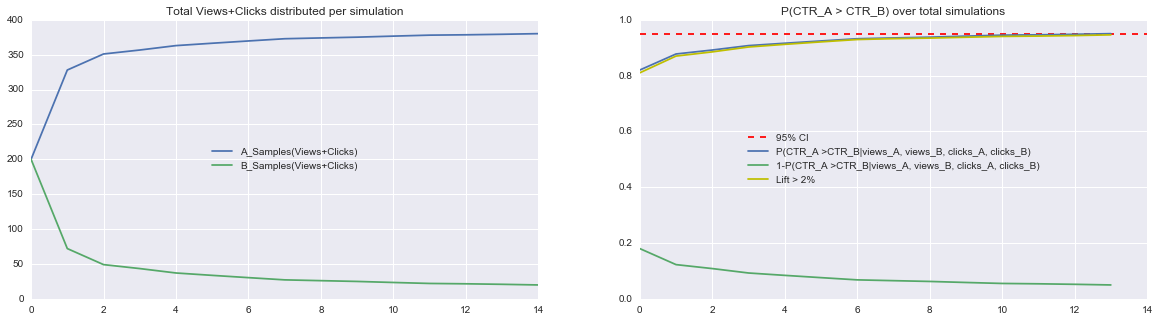

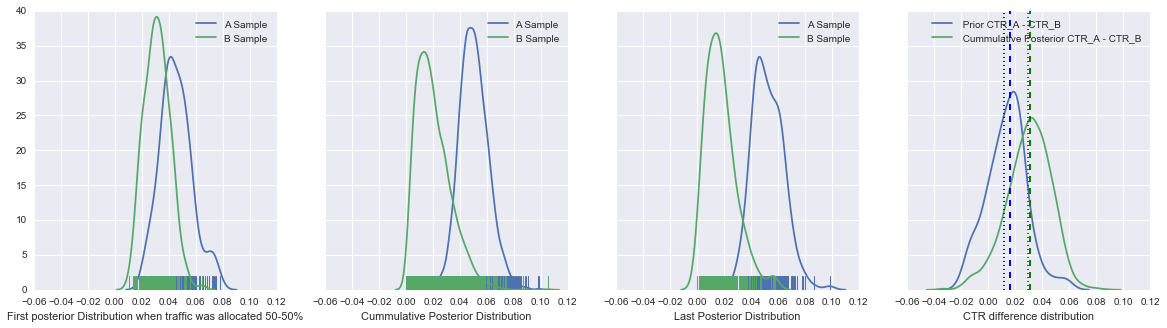

In [239]:
b = baysA_B(200,200)
b.baysA_B()

We can see that posterior probability increased from 0.8 to 0.95 as we increased the simulations. 
Posterior probability distribution at last run and posterior probability distribition for all the run are very different. Lift for probability that it will drive >2%  also increases with increase in P(CTR_a > CTR_b). Instead of 1000 simulations, the process stopped at 14th simulation. Let's consider First posterior distrubition when we saw traffic on first day. It might happen by chance that CTR_A > CTR_B. However when we draw random samples from this distribution, and estimate posterior probability distribution, the two distribution looks fairly near, however as we simulate the two posterior distribution gets separated, we can look at the Last posterior distribution plot. Final posterior distribution has CI for CTR difference smaller than first run as shown in the 4th plot. 2% difference for CI for prior CTR_A - CTR_A does not even lie within the 95% CI, where as for cummulative posterior 95% CI is even greater than 2% approx 3%. This may be due to sampling on 100 samples.